# Building a Handwritten Digits Classifier

In this project, we'll build models that can classify handwritten digits. We'll explore image classification, observe the limitations of traditional machine learning models for image classification, and improve some neural networks for image classification. 

## Working with Image Data

Skikit-learn comes preloaded with some datasets. We'll use the `load_digits()` function to return a copy of the [hand-written digits dataset](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) from UCI.

In [1]:
from sklearn.datasets import load_digits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

digits = load_digits()

In [2]:
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [3]:
labels = pd.Series(digits['target'])
data = pd.DataFrame(digits['data']) # Transforming the NumPy 2D array into a pandas dataframe
data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0


## Visualizing Some Images in the Dataset

We'll be using the [`axes.imshow()`](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.imshow.html?highlight=axes%20imshow#matplotlib.axes.Axes.imshow) function to display multiple images in one matplotlib figure.

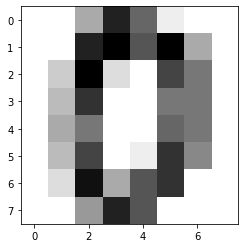

In [4]:
image_one = data.iloc[0]
np_image = image_one.values
np_image = np_image.reshape(8,8) # Reshaping the image so that we can view it

plt.imshow(np_image, cmap='gray_r')

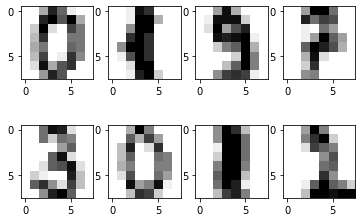

In [5]:
f, axarr = plt.subplots(2, 4) # axarr = axes array

# Displaying the images corresponding to rows 0, 100, 200, and 300
axarr[0, 0].imshow(data.iloc[0].values.reshape(8,8), cmap='gray_r')
axarr[0, 1].imshow(data.iloc[99].values.reshape(8,8), cmap='gray_r')
axarr[0, 2].imshow(data.iloc[199].values.reshape(8,8), cmap='gray_r')
axarr[0, 3].imshow(data.iloc[299].values.reshape(8,8), cmap='gray_r')

# Displaying the images corresponding to rows 1000, 1100, 1200, and 1300
axarr[1, 0].imshow(data.iloc[999].values.reshape(8,8), cmap='gray_r')
axarr[1, 1].imshow(data.iloc[1099].values.reshape(8,8), cmap='gray_r')
axarr[1, 2].imshow(data.iloc[1199].values.reshape(8,8), cmap='gray_r')
axarr[1, 3].imshow(data.iloc[1299].values.reshape(8,8), cmap='gray_r')

## K-Nearest Neighbors Algorithm

The k-nearest neighbors algorithm will compare all images in the test set to all images in the training set and look for similar images. Then the algorithm will find the label with the "nearest" images and assign that as the prediction.

We'll use the `KNeighborsClassifier` package to train and test our model.

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

# Creating the training set and test set out of our data
def train_knn(num_neighbors, train_features, train_labels):
    knn = KNeighborsClassifier(n_neighbors = num_neighbors)
    knn.fit(train_features, train_labels)
    return knn

def test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    accuracy = sum(train_test_df['predicted_label'] == train_test_df['correct_label'])/len(train_test_df)
    return accuracy

def cross_validate(k):
    fold_accuracies = []
    kf = KFold(n_splits = 4)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        model = train_knn(k, train_features, train_labels)
        accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(accuracy)
    return fold_accuracies

knn_one_accuracy = cross_validate(1)
np.mean(knn_one_accuracy)

0.9677233358079684

In [7]:
knn_three_accuracy = cross_validate(3)
np.mean(knn_three_accuracy)

0.9627183865379857

In [8]:
knn_ten_accuracy = cross_validate(10)
np.mean(knn_ten_accuracy)

0.9527097253155159

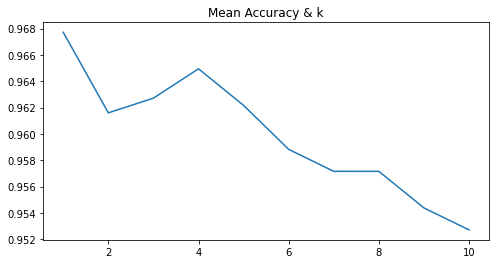

In [9]:
k_values = list(range(1,11)) # Testing multiple values of k for best accuracy
k_accuracy = []

for k in k_values:
    k_accuracies = cross_validate(k)
    k_mean_accuracy = np.mean(k_accuracies)
    k_accuracy.append(k_mean_accuracy)
    
plt.figure(figsize=(8,4))
plt.title('Mean Accuracy & k')
plt.plot(k_values, k_accuracy)

## Neural Network with One Hidden Layer

There are some downsides when using k-nearest neighbors. Many comparisons need to be made between the unseen images and the already seen images, so it uses a lot of memory. There's also no easy way to debug and explore.

Next we'll try using a neural network with just a single hidden layer. We can do this by using the `MLPClassifier` package from scikit-learn. We'll test out this network using hidden layers of 8, 16, 32, 64, 128, and 256 neurons and see which models have the best accuracy and where the models start to overfit.

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier

def train_nn(neuron_arch, train_features, train_labels):
    mlp = MLPClassifier(hidden_layer_sizes = neuron_arch)
    mlp.fit(train_features, train_labels)
    return mlp

def test_nn(model, test_features, test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    accuracy = sum(train_test_df['predicted_label'] == train_test_df['correct_label'])/len(train_test_df)
    return accuracy

def cross_validate(neuron_arch):
    fold_accuracies = []
    kf = KFold(n_splits = 4, random_state=2, shuffle=True)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        
        model = train_nn(neuron_arch, train_features, train_labels)
        accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(accuracy)
    return fold_accuracies

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't co

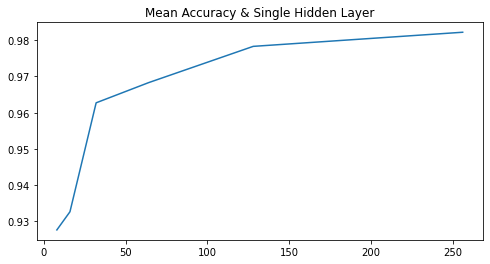

In [11]:
nn_one_neurons = [
    (8,),
    (16,),
    (32,),
    (64,),
    (128,),
    (256,)
]

nn_one_accuracy = []

for n in nn_one_neurons:
    nn_accuracies = cross_validate(n)
    nn_mean_accuracy = np.mean(nn_accuracies)
    nn_one_accuracy.append(nn_mean_accuracy)
    
plt.figure(figsize=(8,4))
plt.title('Mean Accuracy & Single Hidden Layer')

x = [i[0] for i in nn_one_neurons]
plt.plot(x, nn_one_accuracy)

For our single hidden layer neural network, it's clear that adding more neurons significantly helped improve our accuracy. This doesn't tell us anything about false or true positives and negatives. In out k-nearest neighbors algorithm, we achieve approximately 96% accuracy, so there doesn't seem to be any advantage to using a NN with just one hidden layer.

## Neural Network with Two Hidden Layers

Next, we'll test out adding more layers to our neural network to see if we can improve our accuracy. We will just modify the neural network to use 2 hidden layers with 64, 128, and 256 neurons in each layer.

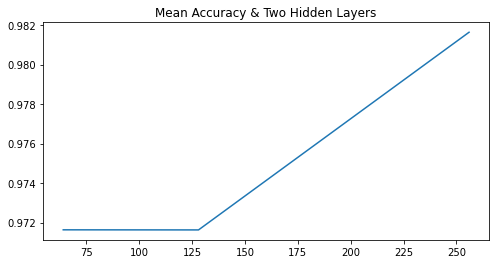

In [12]:
nn_two_neurons = [
    (64,64),
    (128, 128),
    (256, 256)
]

nn_two_accuracy = []

for n in nn_two_neurons:
    nn_accuracies = cross_validate(n)
    nn_mean_accuracy = np.mean(nn_accuracies)
    nn_two_accuracy.append(nn_mean_accuracy)
    
plt.figure(figsize=(8,4))    
plt.title('Mean Accuracy & Two Hidden Layers')    
    
x = [i[0] for i in nn_two_neurons]
plt.plot(x, nn_two_accuracy)

For our neural network with two hidden layers, our accuracy has improved to approximately 95%. Our model is also likely generalizing well and not overfitting.

## Neural Network with Three Hidden Layers

Next, we'll test out adding another layer to our neural network. Since using more hidden layers increases the likelihood that we'll overfit our model, we'll increase the number of folds we use for k-fold cross validation to 6 to help us prevent overfitting.

We will then modify the neural network to use 3 hidden layers and test it with 10, 64, and 128 neurons in each layer.

In [13]:
# The following is the same as in our one hidden layer model, but with `cross_validate` set to six k-folds
def cross_validate_six(neuron_arch):
    fold_accuracies = []
    kf = KFold(n_splits = 6, random_state=2, shuffle=True)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        
        model = train_nn(neuron_arch, train_features, train_labels)
        accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(accuracy)
    return fold_accuracies

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't co

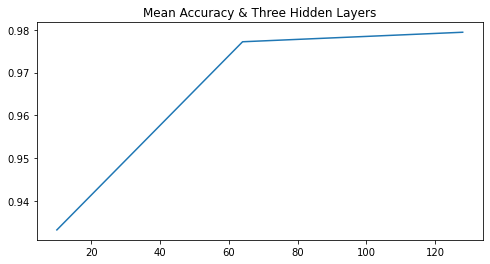

In [14]:
nn_three_neurons = [
    (10, 10, 10),
    (64, 64, 64),
    (128, 128, 128)
]

nn_three_accuracy = []

for n in nn_three_neurons:
    nn_accuracies = cross_validate_six(n)
    nn_mean_accuracy = np.mean(nn_accuracies)
    nn_three_accuracy.append(nn_mean_accuracy)

plt.figure(figsize=(8,4))
plt.title('Mean Accuracy & Three Hidden Layers')
x = [i[0] for i in nn_three_neurons]
plt.plot(x, nn_three_accuracy)

In [15]:
nn_three_accuracy

[0.9332311408398365, 0.9771943515421776, 0.9794184318097362]

It looks like by adding another hidden layer we were able to bring our accuracy all the way up to 98% even with 6-fold cross validation. In computer vision, having more hidden layers and more neurons can improve the neural networks performance.


## Conclusion & Next Steps

In this project we experimented with a few different models to classify handwritten digits.

Some next steps we could take if we would like to continue experimenting with different machine learning models could be to use our existing pipeline and test out decision trees or random forest models. We could experiment using different activation functions, find ways to visualize the weights in our neural network to get an idea for how the neural network is working.

The idea for this project comes from the [DATAQUEST](https://app.dataquest.io/) **Deep Learning Fundamentals** course.